# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
inventory_df = pd.read_csv('/kaggle/input/hospital-supply-chain/inventory_data.csv')
patient_df = pd.read_csv('/kaggle/input/hospital-supply-chain/patient_data.csv')
staff_df = pd.read_csv('/kaggle/input/hospital-supply-chain/staff_data.csv')
financial_df = pd.read_csv('/kaggle/input/hospital-supply-chain/financial_data.csv')

plt.style.use('seaborn-v0_8')

# Data Summary

In [2]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

In [3]:
print("Inventory Data Summary")
display(check(inventory_df))
display(inventory_df.head())
print("Patient Data Summary")
display(check(patient_df))
display(patient_df.head())
print("Staff Data Summary")
display(check(staff_df))
display(staff_df.head())
print("Financial Data Summary")
display(check(financial_df))
display(financial_df.head())

Inventory Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,Date,object,30,30,0,0
1,Item_ID,int64,30,10,0,0
2,Item_Type,object,30,2,0,0
3,Item_Name,object,30,5,0,0
4,Current_Stock,int64,30,30,0,0
5,Min_Required,int64,30,30,0,0
6,Max_Capacity,int64,30,30,0,0
7,Unit_Cost,float64,30,30,0,0
8,Avg_Usage_Per_Day,int64,30,30,0,0
9,Restock_Lead_Time,int64,30,18,0,0


,Date,Item_ID,Item_Type,Item_Name,Current_Stock,Min_Required,Max_Capacity,Unit_Cost,Avg_Usage_Per_Day,Restock_Lead_Time,Vendor_ID
0,2024-10-01,105,Consumable,Surgical Mask,3968,158,5900,14505.22,126,11,V001
1,2024-10-02,100,Equipment,X-ray Machine,1217,219,1137,10026.74,157,28,V001
2,2024-10-03,103,Consumable,Ventilator,1734,572,1270,19121.69,112,14,V002
3,2024-10-04,103,Equipment,X-ray Machine,3349,421,594,12879.98,489,8,V001
4,2024-10-05,107,Equipment,Ventilator,2817,792,3798,8477.39,259,8,V003


Patient Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,Patient_ID,object,50,50,0,0
1,Admission_Date,object,50,50,0,0
2,Discharge_Date,object,50,50,0,0
3,Primary_Diagnosis,object,50,4,0,0
4,Procedure_Performed,object,50,4,0,0
5,Room_Type,object,50,2,0,0
6,Bed_Days,int64,50,14,0,0
7,Supplies_Used,object,50,3,0,0
8,Equipment_Used,object,50,3,0,0
9,Staff_Needed,object,50,3,0,0


,Patient_ID,Admission_Date,Discharge_Date,Primary_Diagnosis,Procedure_Performed,Room_Type,Bed_Days,Supplies_Used,Equipment_Used,Staff_Needed
0,P001,2024-10-26 04:23:05,2024-10-10 04:17:50,Diabetes,Chest X-ray,ICU,10,"Gown, IV",MRI Machine,2 Surgeons
1,P002,2024-10-14 03:45:33,2024-10-08 02:55:45,Pneumonia,MRI,General Ward,11,"Mask, Gown",X-ray Machine,1 Nurse
2,P003,2024-10-07 00:49:50,2024-10-23 12:38:51,Pneumonia,Appendectomy,General Ward,8,"Gloves, IV",MRI Machine,1 Nurse
3,P004,2024-10-05 00:16:50,2024-10-17 21:40:51,Appendicitis,Blood Test,General Ward,11,"Gown, IV",MRI Machine,"1 Nurse, 1 Doctor"
4,P005,2024-10-29 10:13:52,2024-10-20 17:36:51,Pneumonia,MRI,ICU,7,"Mask, Gown",MRI Machine,2 Surgeons


Staff Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,Staff_ID,object,50,50,0,0
1,Staff_Type,object,50,3,0,0
2,Shift_Date,object,50,50,0,0
3,Shift_Start_Time,object,50,3,0,0
4,Shift_End_Time,object,50,3,0,0
5,Current_Assignment,object,50,3,0,0
6,Hours_Worked,int64,50,4,0,0
7,Patients_Assigned,int64,50,9,0,0
8,Overtime_Hours,int64,50,5,0,0


,Staff_ID,Staff_Type,Shift_Date,Shift_Start_Time,Shift_End_Time,Current_Assignment,Hours_Worked,Patients_Assigned,Overtime_Hours
0,S001,Surgeon,2024-10-24 12:24:42,07:00 AM,06:00 PM,ER,9,8,0
1,S002,Technician,2024-10-15 11:22:46,07:00 AM,06:00 PM,ICU Surgery,9,2,3
2,S003,Nurse,2024-10-19 16:27:18,08:00 AM,06:00 PM,ER,8,4,3
3,S004,Nurse,2024-10-04 13:25:31,07:00 AM,06:00 PM,ER,9,8,1
4,S005,Surgeon,2024-10-13 20:43:30,07:00 AM,07:00 PM,ICU Surgery,11,9,4


Financial Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,Date,object,30,30,0,0
1,Expense_Category,object,30,3,0,0
2,Amount,float64,30,30,0,0
3,Description,object,30,3,0,0


,Date,Expense_Category,Amount,Description
0,2024-10-01,Staffing,1365.95,Ventilators
1,2024-10-02,Staffing,46442.73,Surgical masks
2,2024-10-03,Staffing,34964.49,Surgical masks
3,2024-10-04,Supplies,35552.23,Surgical masks
4,2024-10-05,Staffing,30207.18,Ventilators


# EDA

## Analyze Stock Levels vs. Demand
**Visualize how long the hospital's current stock of supplies will last based on average daily usage.**

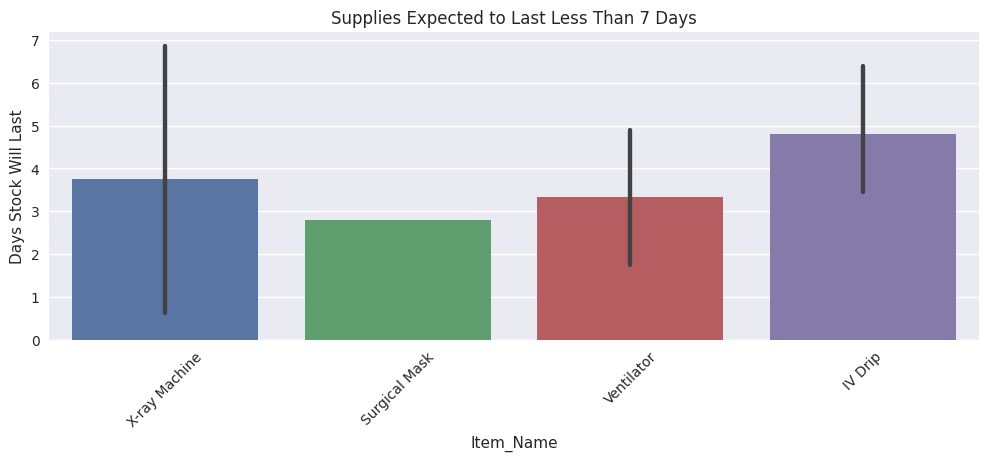

In [4]:
inventory_df['Days_Stock_Last'] = inventory_df['Current_Stock'] / inventory_df['Avg_Usage_Per_Day']

# Visualize supplies that are expected to last less than 7 days
low_stock_items = inventory_df[inventory_df['Days_Stock_Last'] < 7]

plt.figure(figsize=(12, 4))
sns.barplot(x='Item_Name', y='Days_Stock_Last', data=low_stock_items)
plt.title('Supplies Expected to Last Less Than 7 Days')
plt.xticks(rotation=45)
plt.ylabel('Days Stock Will Last')
plt.show()

## Equipment Utilization by Patients
**Which equipment is used most frequently by patients.**

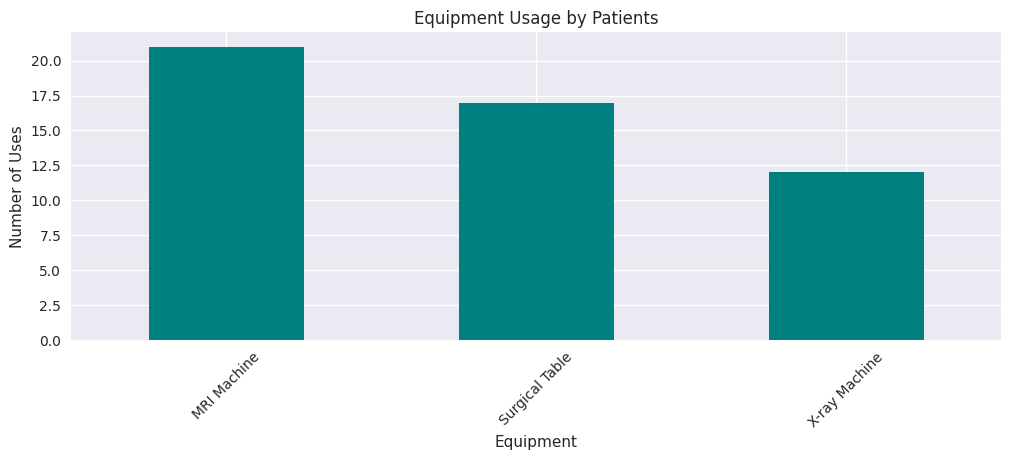

In [5]:
equipment_usage = patient_df['Equipment_Used'].value_counts()

plt.figure(figsize=(12, 4))
equipment_usage.plot(kind='bar', color='teal')
plt.title('Equipment Usage by Patients')
plt.xlabel('Equipment')
plt.ylabel('Number of Uses')
plt.xticks(rotation=45)
plt.show()


## Workload Distribution by Staff Assignment
**Show the average number of patients assigned to staff in different hospital areas.**

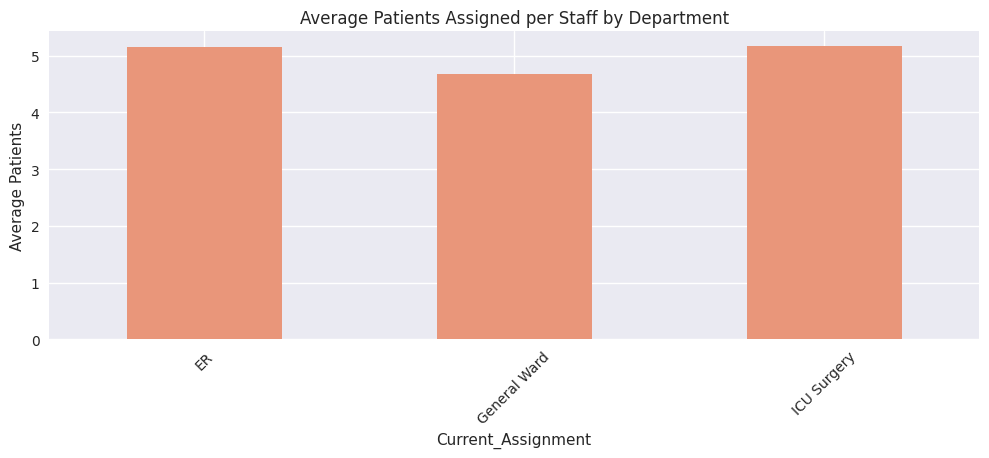

In [6]:
plt.figure(figsize=(12, 4))
staff_df.groupby('Current_Assignment')['Patients_Assigned'].mean().plot(kind='bar', color='darksalmon')
plt.title('Average Patients Assigned per Staff by Department')
plt.ylabel('Average Patients')
plt.xticks(rotation=45)
plt.show()

## Overtime Hours by Staff Type
**Visualize average overtime hours worked by different types of staff.**

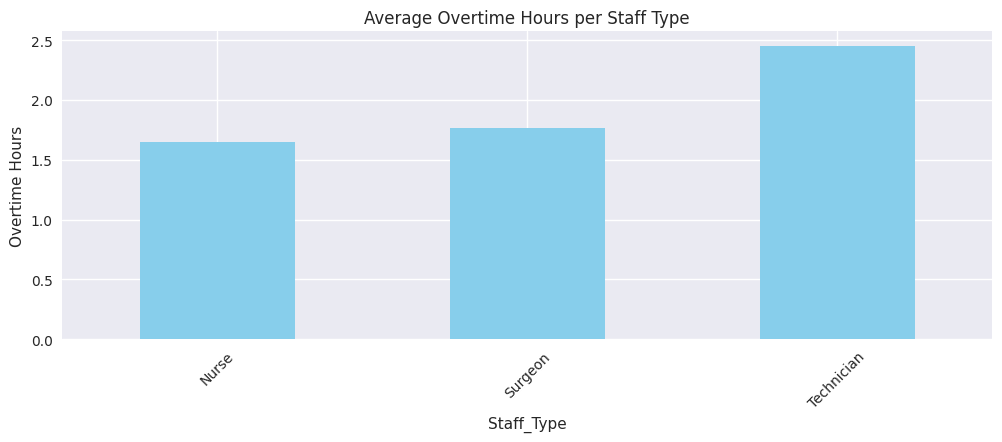

In [7]:
overtime_by_staff = staff_df.groupby('Staff_Type')['Overtime_Hours'].mean()

plt.figure(figsize=(12, 4))
overtime_by_staff.plot(kind='bar', color='skyblue')
plt.title('Average Overtime Hours per Staff Type')
plt.ylabel('Overtime Hours')
plt.xticks(rotation=45)
plt.show()

## Expense Breakdown (Supplies, Equipment, Staffing)
**How financial resources are distributed among different expense categories.**

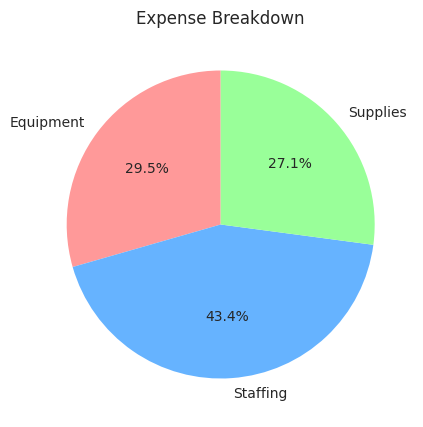

In [8]:
plt.figure(figsize=(5, 5))
financial_df.groupby('Expense_Category')['Amount'].sum().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Expense Breakdown')
plt.ylabel('')
plt.show()